In [18]:
import time
import pickle
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import warnings
import seaborn as sns
from sklearn.model_selection import train_test_split
from dops import *
import autograd
from dops_autograd import *
warnings.filterwarnings('ignore')

In [7]:
with open('./Data/states_bpleq65.p','rb') as f:
    states = pickle.load(f)

In [8]:
patient_ids = list(states.keys())

In [43]:
pid = patient_ids[0]
df_clean = states[pid].loc[:,~states[pid].columns.isin(['Times','bicarbonate_ind', 'bun_ind','creatinine_ind',
                                                        'fio2_ind','glucose_ind','hct_ind','hr_ind','lactate_ind',
                                                        'magnesium_ind','meanbp_ind','platelets_ind','potassium_ind',
                                                        'sodium_ind','spo2_ind','spontaneousrr_ind','temp_ind',
                                                        'urine_ind','wbc_ind'])]

df_clean.insert(0,'ICU_ID',pid)
df_x_train = df_clean.loc[:,~df_clean.columns.isin(['sofa','oasis','saps'])]
df_y_train = df_clean[['sofa','oasis','saps']]

x_train = df_x_train.iloc[0]
y_train = df_y_train.iloc[0]


for pid in patient_ids[1:]:
    df_clean = states[pid].loc[:,~states[pid].columns.isin(['Times','bicarbonate_ind', 'bun_ind','creatinine_ind',
                                                            'fio2_ind','glucose_ind','hct_ind','hr_ind','lactate_ind',
                                                            'magnesium_ind','meanbp_ind','platelets_ind','potassium_ind',
                                                            'sodium_ind','spo2_ind','spontaneousrr_ind','temp_ind',
                                                            'urine_ind','wbc_ind'])]
    
    df_clean.insert(0,'ICU_ID',pid)
    df_x_train = df_clean.loc[:,~df_clean.columns.isin(['sofa','oasis','saps'])]
    df_y_train = df_clean[['sofa','oasis','saps']]
    
    x_train = pd.concat([x_train,df_x_train.iloc[0]],axis=1)
    y_train = pd.concat([y_train,df_y_train.iloc[0]],axis=1)

In [44]:
x_train = x_train.T.reset_index(drop=True)
y_train = y_train.T.reset_index(drop=True)

In [46]:
x_train = x_train.drop(['ICU_ID'],axis=1)

In [49]:
##Multilevel Transformation
multilevel_header = ["age1","age2","age3","age4","age5","is_F",
                     "weight","surg_ICU","is_not_white","is_emergency","is_urgent",
                     "hrs_from_admit_to_icu","bicarbonate1","bicarbonate2","bun","creatinine",
                     "fio2","glucose","hct","hr1","hr2","hr3","hr4","lactate","magnesium","meanbp",
                     "platelets","potassium1","potassium2","sodium1","sodium2","spo2","spontaneousrr","temp","urine1","urine2","wbc"]

multilevel_df = pd.DataFrame(0,index=np.arange(len(x_train)),columns=multilevel_header)

for i,row in x_train.iterrows():
    if 40 < row['age'] <= 59:
        multilevel_df.iloc[i]['age1'] = 1
    elif 60 < row['age'] <= 69:
        multilevel_df.iloc[i]['age2'] = 1
    elif 70 < row['age'] <= 74:
        multilevel_df.iloc[i]['age3'] = 1
    elif 75 < row['age'] <= 79:
        multilevel_df.iloc[i]['age4'] = 1
    elif row['age'] > 80:
        multilevel_df.iloc[i]['age5'] = 1 
    
    multilevel_df.iloc[i]['is_F'] = 1 if row['is_F'] == 1 else 0
    multilevel_df.iloc[i]['weight'] = 1 if row['weight'] >= 75 else 0
    multilevel_df.iloc[i]['hrs_from_admit_to_icu'] = 1 if row['hrs_from_admit_to_icu'] >= 1 else 0
    
    if 15 <= row['bicarbonate'] <= 19:
        multilevel_df.iloc[i]['bicarbonate1'] = 1
    elif row['bicarbonate'] < 15:
        multilevel_df.iloc[i]['bicarbonate2'] = 1
    
    multilevel_df.iloc[i]['bun'] = 0 if 7 <= row['bun'] <= 12 else 1
    multilevel_df.iloc[i]['creatinine'] = 0 if 0.5 <= row['creatinine'] <= 1.2 else 1
    multilevel_df.iloc[i]['fio2'] = 1 if row['fio2'] >= 0.5 else 0
    multilevel_df.iloc[i]['glucose'] = 1 if row['glucose'] >= 125 else 0
    multilevel_df.iloc[i]['hct'] = 0 if 37 <= row['hct'] <= 52 else 1
    
    if 40 <= row['hr'] <= 69:
        multilevel_df.iloc[i]['hr1'] = 1
    elif 120 <= row['hr'] <= 159:
        multilevel_df.iloc[i]['hr2'] = 1
    elif row['hr'] >= 160:
        multilevel_df.iloc[i]['hr3'] = 1
    elif row['hr'] < 40:
        multilevel_df.iloc[i]['hr4'] = 1
    
    multilevel_df.iloc[i]['lactate'] = 1 if row['lactate'] >= 2 else 0
    multilevel_df.iloc[i]['magnesium'] = 0 if 1.5 <= row['magnesium'] <= 2.5 else 1
    multilevel_df.iloc[i]['meanbp'] = 1 if row['meanbp'] <= 65 else 0
    multilevel_df.iloc[i]['platelets'] = 0 if 140 <= row['platelets'] <= 450 else 1
    
    if row['potassium'] >= 5:
        multilevel_df.iloc[i]['potassium1'] = 1
    elif row['potassium'] < 3:
        multilevel_df.iloc[i]['potassium2'] = 1
        
    if row['sodium'] >= 145:
        multilevel_df.iloc[i]['sodium1'] = 1
    elif row['sodium'] < 125:
        multilevel_df.iloc[i]['sodium2'] = 1
    
    multilevel_df.iloc[i]['spo2'] = 1 if row['spo2'] <= 95 else 0
    multilevel_df.iloc[i]['spontaneousrr'] = 0 if 12 <= row['spontaneousrr'] <= 25 else 1
    multilevel_df.iloc[i]['temp'] = 1 if row['temp'] >= 39 else 0
    
    if 50 <= row['urine'] <= 99:
        multilevel_df.iloc[i]['urine1'] = 1
    elif row['urine'] < 50:
        multilevel_df.iloc[i]['urine2'] = 1
        
    multilevel_df.iloc[i]['wbc'] = 0 if 4.3 <= row['wbc'] <= 10.8 else 1


In [69]:
## Binary Transformation
##1's indicate the patient's feature is in bad condition, 0's means feature values in normal

bilevel_df = x_train.copy()

bilevel_df['age'] = np.where(bilevel_df['age']>=60,1,0)
bilevel_df['weight'] = np.where(bilevel_df['weight']>=75,1,0)
bilevel_df['hrs_from_admit_to_icu'] = np.where(bilevel_df['hrs_from_admit_to_icu']>=1,1,0)
bilevel_df['bicarbonate'] = np.where(bilevel_df['bicarbonate']<=20,1,0)
bilevel_df['bun'] = np.where(np.logical_and(bilevel_df['bun']>=7,bilevel_df['bun']<=20),0,1)
bilevel_df['creatinine'] = np.where(np.logical_and(bilevel_df['creatinine']>=0.5,bilevel_df['creatinine']<=1.2),0,1)
bilevel_df['fio2'] = np.where(bilevel_df['fio2']>=0.5,1,0)
bilevel_df['glucose'] = np.where(bilevel_df['glucose']>=125,1,0)
bilevel_df['hct'] = np.where(np.logical_and(bilevel_df['hct']>=37,bilevel_df['hct']<=52),0,1)
bilevel_df['hr'] = np.where(np.logical_and(bilevel_df['hr']>=70,bilevel_df['hr']<=119),0,1)
bilevel_df['lactate'] = np.where(bilevel_df['lactate']>=2,1,0)
bilevel_df['magnesium'] = np.where(np.logical_and(bilevel_df['magnesium']>=1.5,bilevel_df['magnesium']<=2.5),0,1)
bilevel_df['meanbp'] = np.where(bilevel_df['meanbp']<=65,1,0)
bilevel_df['platelets'] = np.where(np.logical_and(bilevel_df['platelets']>=140,bilevel_df['platelets']<=450),0,1)
bilevel_df['potassium'] = np.where(np.logical_and(bilevel_df['potassium']>=3,bilevel_df['potassium']<=4.9),0,1)
bilevel_df['sodium'] = np.where(np.logical_and(bilevel_df['sodium']>=125,bilevel_df['potassium']<=144),0,1)
bilevel_df['spo2'] = np.where(bilevel_df['spo2']<=95,1,0)
bilevel_df['spontaneousrr'] = np.where(np.logical_and(bilevel_df['spontaneousrr']>=12,bilevel_df['spontaneousrr']<=25),0,1)
bilevel_df['temp'] = np.where(bilevel_df['temp']>=39,1,0)
bilevel_df['urine'] = np.where(bilevel_df['urine']<=100,1,0)
bilevel_df['wbc'] = np.where(np.logical_and(bilevel_df['wbc']>=4.3,bilevel_df['wbc']<=10.8),0,1)


In [81]:
manual_bilevel_coverage = np.array([[1,0,0,1,0,0,0,0,1,1,1,1,1,1,0,1,1,1,1,1,1,1,1,0,1,1],
[0,1,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0],
[0,0,1,0,0,0,0,0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,0,0,1,1],
[1,0,0,1,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],
[0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],
[0,0,0,1,0,1,1,1,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0],
[0,0,0,1,0,1,1,1,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0],
[0,0,0,0,0,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],
[1,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,1,1,0,0,0,0,0],
[1,0,1,0,0,0,0,0,0,1,1,0,1,0,0,0,0,1,0,0,0,0,0,0,1,0],
[1,1,1,0,0,0,0,0,0,1,1,0,1,0,0,0,0,1,0,0,0,0,0,0,1,0],
[1,0,1,0,0,0,0,0,0,0,0,1,0,0,0,1,0,1,0,0,0,1,1,0,0,0],
[1,0,1,0,0,0,0,0,0,1,1,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0],
[1,1,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,1],
[0,0,1,0,0,1,1,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,1,0,0,0],
[1,0,1,0,0,0,0,0,0,0,0,1,0,0,0,1,0,1,0,0,0,1,1,0,0,0],
[1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,1,1,0,0,0,0,0],
[1,0,1,0,0,1,1,0,1,1,1,1,1,0,1,1,1,1,0,0,1,1,1,1,1,1],
[1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1],
[1,0,1,0,0,0,0,0,1,0,0,0,0,1,0,0,1,0,0,1,1,0,0,0,0,0],
[1,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,1,1,0,1,1,0,0,0,0,0],
[1,0,1,0,0,0,0,0,0,0,0,1,0,0,0,1,0,1,0,0,0,1,1,0,0,0],
[1,0,0,0,0,0,0,0,0,0,0,1,0,0,1,1,0,1,0,0,0,1,1,0,0,0],
[0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,1],
[1,0,1,0,0,0,0,0,0,1,1,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0],
[1,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,1,0,0,0,0,1,0,1]])

In [51]:
manual_multilevel_coverage = np.array([[1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],
                                     [0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],
                                     [0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],
                                     [0,0,0,1,0,0,0,1,0,0,0,0,1,0,1,1,1,1,1,0,0,0,0,1,1,1,1,1,0,1,0,1,1,0,1,0,1],
                                     [0,0,0,0,1,0,0,1,0,0,1,0,1,0,1,1,1,1,1,0,0,0,0,1,1,1,1,0,1,0,1,1,1,0,0,1,1],
                                     [0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],
                                     [0,0,0,0,0,0,1,0,0,0,0,0,1,0,1,1,1,1,1,0,0,0,0,1,1,1,1,1,0,1,0,1,0,0,1,0,1],
                                     [0,0,0,0,0,0,0,1,0,1,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0],
                                     [0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],
                                     [0,0,0,0,0,0,0,1,0,1,1,1,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,1,0,1,0,0,0,0,0,0],
                                     [0,0,0,0,0,0,0,1,0,1,1,1,1,0,0,0,0,0,0,1,0,0,0,0,0,1,0,1,0,1,0,0,0,0,0,0,0],
                                     [0,0,0,0,0,0,0,0,0,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],
                                     [0,0,0,0,0,0,1,0,0,0,1,0,1,0,0,0,0,0,0,1,0,0,0,0,0,1,0,1,0,1,0,0,0,0,0,0,0],
                                     [0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0],
                                     [0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,1,0,1,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,1,0,0],
                                     [0,0,0,0,0,1,1,0,0,0,0,0,0,0,1,1,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0],
                                     [0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,1,0,0,1,0,0,0,1,0,1,0,1,0,1,0,1,1,0,0,0,0],
                                     [0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,1,0,1,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0],
                                     [0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,1],
                                     [0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0],
                                     [0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0],
                                     [0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,1,0,0,0,1,0,1,1,1,0,1,0,1,0,0,1,0,1,0,0],
                                     [0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,1,0,0,0,0,1,1,1,1,0,0,1,0,1,0,1,0,0,1,0],
                                     [0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,1,0,0,0,0,0,1,1,0,0,0,0],
                                     [0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,1,0,1,0,0,0,0,0,0,0],
                                     [0,0,0,0,0,0,1,0,0,1,1,0,1,0,1,1,1,1,0,1,0,0,0,1,1,1,0,0,0,1,0,1,1,1,1,0,1],
                                     [0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1],
                                     [0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,1,1,0,0,0,0,1,1,0,1,0,1,0,0,0,0,0,0,0],
                                     [0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,1,0,0,0,1,1,0,0,1,0,1,0,0,0,0,0,0],
                                     [0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,1,1,0,1,0,1,0,0,0,0,0,0,0],
                                     [0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,1,0,0,0,0,1,0,1,0,0,0,0,0,0],
                                     [0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,1,0,0,0,0,0,1,1,0,0,0,0],
                                     [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,1,0,1,0,0,0,0,0,1,1,0,0,0,0],
                                     [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,1],
                                     [0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,1,0,0],
                                     [0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,1,0],
                                     [0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,1,0,0,0,0,0,0,1,0,0,1]])

In [73]:
multilevel_x_train = multilevel_df.values
bilevel_x_train = bilevel_df.values

len(multilevel_df) == len(bilevel_df)

True

Starting DOPS when dropping ['lactate', 'platelets']
Iter 40, theta: [0.98521912 0.92654003 0.98521912 0.98521912 0.64574509 0.98521912
 0.98521912 0.97788025 0.98069515 0.98521912 0.98521912 0.98521912
 0.98521912 0.9827058  0.95361839 0.98521912 0.97399298 0.98521912
 0.97316479 0.9827058  0.98069515 0.98521912 0.98521912 0.72587594
 0.98521912 0.9827058 ], gradient: [-0.0164232  -0.01533165 -0.0164232  -0.0164232  -0.00949678 -0.0164232
 -0.0164232  -0.01626307 -0.01634779 -0.0164232  -0.0164232  -0.0164232
 -0.0164232  -0.01638131 -0.01582083 -0.0164232  -0.01623607 -0.0164232
 -0.01618446 -0.01638131 -0.01634779 -0.0164232  -0.0164232  -0.01076953
 -0.0164232  -0.01638131]
Iter 80, theta: [0.99978153 0.94013456 0.99978153 0.99978153 0.65416586 0.99978153
 0.99978153 0.99230066 0.99519069 0.99978153 0.99978153 0.99978153
 0.99978153 0.99723106 0.96764668 0.99978153 0.98838946 0.99978153
 0.98751551 0.99723106 0.99519069 0.99978153 0.99978153 0.73542525
 0.99978153 0.99723106], grad

Iter 120, theta: [1.04838621 1.0658616  1.01411236 1.04892507 0.72099834 0.92752379
 0.99999677 0.99999677 0.99999677 0.99999677 0.80502672 0.80857593
 0.88585729 0.67569374 0.98639138 0.99659542 0.99999677 0.98639138
 0.99489475 0.99999677 0.67535357 0.99999677 0.99999677 0.99999677
 0.87905456 0.99999677 0.93364617 0.99999677 0.50383753 0.99999677
 0.50383753 0.99999677 0.99999677 0.81537509 0.99659542 0.68564878
 0.99489475], gradient: [ 2.09906131e-02 -3.68103059e-06 -3.65621741e-06 -5.86449274e-03
 -1.51362776e-02 -3.26095842e-06 -3.58805113e-06 -3.58805113e-06
 -3.58805113e-06 -3.58805113e-06 -2.70791512e-06  4.40823176e-02
 -3.07217053e-06  1.51321222e-02 -3.53109794e-06 -3.57584688e-06
 -3.58805113e-06 -3.53109794e-06 -3.56974475e-06 -3.58805113e-06
  1.51320823e-02 -3.58805113e-06 -3.58805113e-06 -3.58805113e-06
 -3.08227223e-06 -3.58805113e-06 -3.34184480e-06 -3.58805113e-06
 -1.27649949e-06 -3.58805113e-06 -1.27649949e-06 -3.58805113e-06
 -3.58805113e-06 -4.40870707e-02 -3.5

Iter 80, theta: [0.99978153 0.94880663 0.99978153 0.99978153 0.76584822 0.99751445
 0.99751445 0.98468116 0.97162167 0.99638091 0.99978153 0.99978153
 0.99071371 0.99978153 0.9589832  0.99978153 0.96142031 0.99978153
 0.98031753 0.99978153 0.97162167 0.99978153 0.99978153 0.76571168
 0.99638091 0.99978153], gradient: [-0.00024275 -0.00022817 -0.00024275 -0.00024275 -0.10240131 -0.0002422
 -0.0002422  -0.00023908 -0.00023536 -0.00024192 -0.00024275 -0.00024275
 -0.00024    -0.00024275 -0.00023174 -0.00024275 -0.00023233 -0.00024275
 -0.00023747 -0.00024275 -0.00023536 -0.00024275 -0.00024275  0.10205952
 -0.00024192 -0.00024275]
Iter 120, theta: [0.99999677 0.94900895 0.99999677 0.99999677 0.76062785 0.9977292
 0.9977292  0.98489316 0.97183036 0.99659542 0.99999677 0.99999677
 0.99092651 0.99999677 0.95918869 0.99999677 0.96162632 0.99999677
 0.9805281  0.99999677 0.97183036 0.99999677 0.99999677 0.77123511
 0.99659542 0.99999677], gradient: [-3.58805113e-06 -3.37255885e-06 -3.58805113e

Iter 120, theta: [1.05444178 1.10157558 0.99355853 1.09727511 0.68658788 0.93228573
 0.99999677 0.99999677 0.99999677 0.99999677 0.74841855 0.82261687
 0.92825344 0.7646227  0.98843218 0.99999677 0.99999677 0.98843218
 0.99319407 0.99999677 0.70223252 0.99999677 0.99999677 0.99999677
 0.90461407 0.99999677 0.97480252 0.99999677 0.51039714 0.99999677
 0.51039714 0.99999677 0.99999677 0.83065865 1.01360216 0.6780593
 0.98911246], gradient: [ 7.52681981e-03 -4.02323688e-06 -3.53470465e-06 -4.22744720e-06
 -7.53273671e-03 -3.21641138e-06 -3.58805113e-06 -3.58805113e-06
 -3.58805113e-06 -3.58805113e-06 -2.49878580e-06 -2.42194705e-06
 -7.53397339e-03  7.52808066e-03 -3.54655666e-06 -3.58805113e-06
 -3.58805113e-06 -3.54655666e-06 -3.56364262e-06 -3.58805113e-06
  7.52863126e-03 -3.58805113e-06 -3.58805113e-06 -3.58805113e-06
 -7.53387230e-03 -3.58805113e-06 -3.46510779e-06 -3.58805113e-06
 -1.45249422e-06 -3.58805113e-06 -1.45249422e-06 -3.58805113e-06
 -3.58805113e-06 -2.42390465e-06 -3.64

Iter 80, theta: [0.99978153 0.94013456 0.99978153 0.99978153 0.65416586 0.99978153
 0.99978153 0.99230066 0.99519069 0.99978153 0.99978153 0.99978153
 0.99978153 0.99723106 0.96764668 0.99978153 0.98838946 0.99978153
 0.98751551 0.99723106 0.99519069 0.99978153 0.99978153 0.73542525
 0.99978153 0.99723106], gradient: [-0.00024275 -0.00022662 -0.00024275 -0.00024275 -0.00014037 -0.00024275
 -0.00024275 -0.00024038 -0.00024163 -0.00024275 -0.00024275 -0.00024275
 -0.00024275 -0.00024213 -0.00023385 -0.00024275 -0.00023998 -0.00024275
 -0.00023922 -0.00024213 -0.00024163 -0.00024275 -0.00024275 -0.00015918
 -0.00024275 -0.00024213]
Iter 120, theta: [0.99999677 0.9403355  0.99999677 0.99999677 0.65429033 0.99999677
 0.99999677 0.99251381 0.99540495 0.99999677 0.99999677 0.99999677
 0.99999677 0.99744576 0.96785403 0.99999677 0.98860225 0.99999677
 0.98772762 0.99744576 0.99540495 0.99999677 0.99999677 0.7355664
 0.99999677 0.99744576], gradient: [-3.58805113e-06 -3.34957417e-06 -3.58805113

Iter 120, theta: [1.05275119 1.06586181 1.01411236 1.051348   0.71421022 0.92752379
 0.99999677 0.99999677 0.99999677 0.99999677 0.80502672 0.80177396
 0.88585729 0.68248189 0.96442848 0.98959836 0.99999677 0.96442848
 0.99489475 0.99999677 0.68214151 0.99999677 0.99999677 0.99999677
 0.87905456 0.99999677 0.94674136 0.99999677 0.50383753 0.99999677
 0.50383753 0.99999677 0.99999677 0.80176901 0.98211539 0.67886087
 0.99489475], gradient: [ 3.16485257e-03 -3.44774166e-06 -3.65621741e-06 -3.17234270e-03
 -2.90038786e-06 -3.26095842e-06 -3.58805113e-06 -3.58805113e-06
 -3.58805113e-06 -3.58805113e-06 -2.70791512e-06 -3.15026430e-02
 -3.07217053e-06 -1.22303956e-06 -3.33651095e-06 -3.55074098e-06
 -3.58805113e-06 -3.33651095e-06 -3.56974475e-06 -3.58805113e-06
 -1.49623322e-06 -3.58805113e-06 -3.58805113e-06 -3.58805113e-06
 -3.08227223e-06 -3.58805113e-06 -3.38883119e-06 -3.58805113e-06
 -1.27649949e-06 -3.58805113e-06 -1.27649949e-06 -3.58805113e-06
 -3.58805113e-06  3.14980149e-02 -3.5

KeyboardInterrupt: 

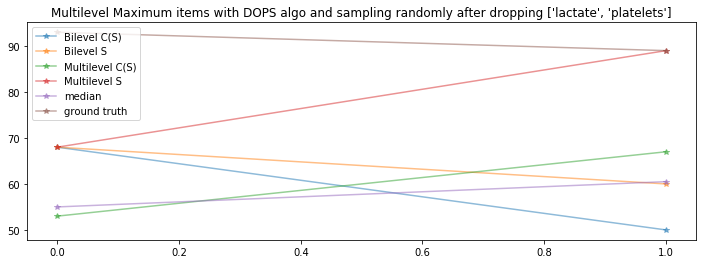

In [87]:
from itertools import combinations

harder_measure = ['lactate','platelets','bun','hct','creatinine','magnesium','potassium','bicarbonate']

# Randomly select 1000 items from the master
for item in combinations(harder_measure,2):
    
    measure = list(item)
    print("Starting DOPS when dropping " + str(measure))

    bi_preds = []
    bi_preds_cover_self = []
    multi_preds = []
    multi_preds_cover_self = []
    truths = []
    t1 = time.time()
    repeat = 2
    for i in range(repeat):
        np.random.seed(i)
        index = np.random.choice(len(multilevel_df), size=1000, replace=False)
        bi_x, multi_x, y = bilevel_df.iloc[index], multilevel_df.iloc[index], y_train.iloc[index]
        bi_x[measure] = 0.0
        multi_x[measure] = 0.0
        bi_x_train_dops = bi_x.values
        multi_x_train_dops = multi_x.values
        y_train_dops = y['saps'].values + y['oasis'].values + y['sofa'].values
        bi_X_train, bi_X_test,Y_train,Y_test = train_test_split(bi_x_train_dops,y_train_dops,test_size=0.02,random_state=i)
        multi_X_train, multi_X_test,Y_train,Y_test = train_test_split(multi_x_train_dops,y_train_dops,test_size=0.02,random_state=i)
        test_len = len(Y_test)
        bi_res1, bi_pred_theta, bi_max_item_index = dops(bi_X_train, Y_train, bi_X_test, manual_bilevel_coverage, test_len, 0.8, \
                                               np.zeros(26), batch_size=64, eta=0.1, iters=200, print_every=40)
        bi_res2, bi_pred_theta, bi_max_item_index = dops(bi_X_train, Y_train, bi_X_test, np.eye(len(manual_bilevel_coverage)), test_len, 0.8, \
                                               np.zeros(26), batch_size=64, eta=0.1, iters=200, print_every=40)
        
        multi_res1, multi_pred_theta, multi_max_item_index = dops(multi_X_train, Y_train, multi_X_test, manual_multilevel_coverage, test_len, 0.8, \
                                               np.zeros(37), batch_size=64, eta=0.1, iters=200, print_every=40)
        multi_res2, multi_pred_theta, multi_max_item_index = dops(multi_X_train, Y_train, multi_X_test, np.eye(len(manual_multilevel_coverage)), test_len, 0.8, \
                                               np.zeros(37), batch_size=64, eta=0.1, iters=200, print_every=40)
        
        bi_preds.append(bi_res1)
        bi_preds_cover_self.append(bi_res2)
        multi_preds.append(multi_res1)
        multi_preds_cover_self.append(multi_res2)
        truths.append(Y_test)
    
    bi_pred = []
    bi_pred_cover_self = []
    multi_pred = []
    multi_pred_cover_self = []
    real = []
    rand = []
    for i in range(repeat):
        bi_pred.append(truths[i][np.argmax(bi_preds[i])])
        bi_pred_cover_self.append(truths[i][np.argmax(bi_preds_cover_self[i])])
        multi_pred.append(truths[i][np.argmax(multi_preds[i])])
        multi_pred_cover_self.append(truths[i][np.argmax(multi_preds_cover_self[i])])
        real.append(max(truths[i]))
        rand.append(np.median(truths[i]))
    t2 = time.time()
    print('Used time: %.2fs' % (t2-t1))

    plt.figure(figsize=(12,4))
    plt.plot(np.arange(0,repeat), bi_pred, '*-', alpha=0.5, label='Bilevel C(S)')
    plt.plot(np.arange(0,repeat), bi_pred_cover_self, '*-', alpha=0.5, label='Bilevel S')
    plt.plot(np.arange(0,repeat), multi_pred, '*-', alpha=0.5, label='Multilevel C(S)')
    plt.plot(np.arange(0,repeat), multi_pred_cover_self, '*-', alpha=0.5, label='Multilevel S')
    plt.plot(np.arange(0,repeat), rand, '*-', alpha=0.5, label='median')
    plt.plot(np.arange(0,repeat), real, '*-', alpha=0.5, label='ground truth')
    plt.legend()
    plt.title('Multilevel Maximum items with DOPS algo and sampling randomly after dropping ' + str(measure))
    plt.savefig("Multilevel results after dropping " + str(measure))

## Correlation

In [17]:
df_for_median = x_train.drop(['ICU_ID','is_F','is_not_white','is_emergency','is_urgent','surg_ICU'],axis=1)
median_dict = {}
for column in df_for_median.columns:
    #median_dict[column] = np.median(df_for_median[column].values)
    print(column,np.sum(df_for_median[column].values))
    #print(column)

age 9033
weight 7590
hrs_from_admit_to_icu 6193
bicarbonate 1937
bun 8054
creatinine 3953
fio2 13513
glucose 8093
hct 9578
hr 1308
lactate 3745
magnesium 197
meanbp 925
platelets 2586
potassium 1997
sodium 189
spo2 1303
spontaneousrr 1047
temp 98
urine 12526
wbc 5878


In [12]:
corr = x_train.corr()

In [13]:
corr

,age,is_F,weight,surg_ICU,is_not_white,is_emergency,is_urgent,hrs_from_admit_to_icu,bicarbonate,bun,...,magnesium,meanbp,platelets,potassium,sodium,spo2,spontaneousrr,temp,urine,wbc
age,1.000000,0.109126,-0.187078,-0.073283,-0.088023,0.057241,-0.003368,-0.044161,0.032949,0.136856,...,0.004366,-0.031428,-0.005977,0.047130,0.042847,-0.000135,0.015986,-0.032004,-0.017073,-0.008254
is_F,0.109126,1.000000,-0.259883,-0.065285,0.016332,0.033321,0.006128,-0.027789,-0.011121,-0.057222,...,-0.020733,-0.016264,0.088267,-0.113056,0.014797,-0.004342,0.005248,-0.034222,-0.000495,0.012152
weight,-0.187078,-0.259883,1.000000,0.009041,-0.009096,-0.047079,0.011968,0.005540,0.049432,0.017612,...,0.007538,0.011983,-0.039100,0.057337,-0.007765,-0.034777,0.010274,0.044819,0.015783,0.018920
surg_ICU,-0.073283,-0.065285,0.009041,1.000000,-0.019823,-0.284317,-0.025962,0.016883,0.075643,-0.203550,...,-0.001981,0.018206,-0.013316,0.003580,0.026979,0.087530,-0.073644,0.030297,-0.057513,-0.016113
is_not_white,-0.088023,0.016332,-0.009096,-0.019823,1.000000,0.075226,-0.007769,-0.000554,-0.046291,0.003553,...,-0.000641,0.035192,-0.007403,-0.011931,0.032114,0.027642,0.005859,0.004925,0.000452,0.003059
is_emergency,0.057241,0.033321,-0.047079,-0.284317,0.075226,1.000000,-0.244773,-0.008973,-0.077687,0.088885,...,0.027889,-0.015745,0.101302,-0.084374,0.014624,-0.010731,0.077672,0.032055,0.009719,0.056082
is_urgent,-0.003368,0.006128,0.011968,-0.025962,-0.007769,-0.244773,1.000000,0.012720,-0.011465,0.012321,...,-0.017625,-0.008429,-0.022543,-0.001627,-0.015812,-0.028666,-0.017750,-0.024858,0.026245,-0.003813
hrs_from_admit_to_icu,-0.044161,-0.027789,0.005540,0.016883,-0.000554,-0.008973,0.012720,1.000000,0.040889,0.096752,...,-0.013401,-0.032468,0.011670,0.010775,-0.040034,-0.073669,0.103640,-0.043442,0.049887,-0.022674
bicarbonate,0.032949,-0.011121,0.049432,0.075643,-0.046291,-0.077687,-0.011465,0.040889,1.000000,-0.197945,...,0.028198,0.032539,0.029637,-0.092072,0.115025,-0.013714,-0.038843,0.034983,0.032258,-0.146713
bun,0.136856,-0.057222,0.017612,-0.203550,0.003553,0.088885,0.012321,0.096752,-0.197945,1.000000,...,0.116389,-0.082670,-0.051184,0.282569,-0.009714,-0.043446,0.039095,-0.066756,-0.038508,0.098102


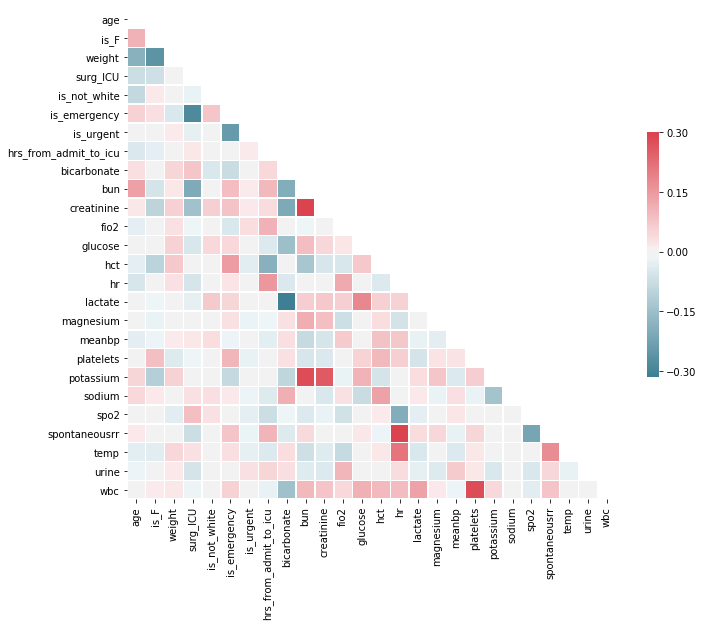

In [22]:
# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

In [26]:
coverage = (corr.values > 0.1).astype(int)
coverage

array([[1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0],
       [1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0],
       [0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0],
       [0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0],
       [0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0],
       [0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0,
        0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0,
        1, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0,
        0, 0, 0, 0],
       [1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0,
        0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 

In [ ]:
levels = {Age: 5,
          Bicarbonate: 2,
          Sodium: 2,
          Potassium:2,
          urine: 2,
          HR: 4}
len(levels)